In [1]:
import os
import math
import numpy as np 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from vecstack import stacking
plt.rcParams['font.family'] = 'AppleGothic'
# Neural Network Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
# 파일시스템으로부터 데이터 파일 읽기
primitive_df = pd.read_csv(os.path.relpath('./train_data.csv'), index_col='id')
dist_hospital = pd.read_csv('./id_dist_hospital.csv', index_col='id')
dist_station = pd.read_csv('./id_dist_station.csv', index_col='id')
dist_hangang = pd.read_csv('./id_dist_hangang.csv', index_col='id')

In [3]:
# 데이터 병합
primitive_df = pd.concat([primitive_df, dist_hangang, dist_station, dist_hospital], axis=1)

In [4]:
# 잉여 feature 삭제
train_df = primitive_df.drop([ 
            'exclusivePyeong', 
            'supplyPyeong', 
            'pyeongNo', 
            'complexName.1', 
            'completionMonth',
            'roadAddress.1', 
            'complexNo',
            'completionYear', 
            'rentCount', 
            'dealCount', 
            'Unnamed: 0', 
            'cortarNo'], axis=1)

In [5]:
# 모든 숫자형 컬럼에 대해서 0 -> NaN으로 변경
def replaceZeroToNull(x):
    if x == 0:
        return None
    return x

numeric_cols = train_df.select_dtypes(include=[np.number]).columns.to_list()

for col in numeric_cols:
    train_df[col] = train_df[col].apply(lambda x: replaceZeroToNull(x))

# contactDate컬럼 타입 변경 (string -> Date)
train_df['contactDate'] = train_df['contactDate'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [6]:
# brand열: 건설회사
def cleanBrand(raw):
    if pd.isnull(raw):
        return '기타'
    
    raw = raw.split(',')[0]
    raw = raw.split('외')[0]
    raw = raw.replace('(주)', '')
    raw = raw.replace('쭈', '')
    raw = raw.replace('(', '')
    raw = raw.replace(')', '')
    raw = raw.replace('', '')
    raw = raw.replace('M&C', '')
    raw = raw.replace('㈜', '')
    raw = raw.replace('주식회사', '')
    raw = raw.replace('주식회서', '')
    raw = raw.replace('건설', '')
    raw = raw.replace('종합', '')
    raw = raw.replace('종합', '')
    raw = raw.strip()
    raw = raw.split(' ')[0]

    return raw

train_df['brand'] = train_df['constructionCompanyName'].apply(cleanBrand)

In [7]:
# 데이터상에서 100회 이하로 언급되는 건설회사 -> 기타로 취급
brands = train_df['brand'].value_counts() > 100

noNamedBrands = []
for brand, isNamed in zip(brands.index, brands.values):
    if not isNamed:
        noNamedBrands.append(brand)
        
def extendEtc(name):
    if name in noNamedBrands:
        return '기타'
    return name

train_df['brand'] = train_df['brand'].apply(extendEtc)

train_df.drop('constructionCompanyName', axis=1, inplace=True)

In [8]:
# contactDay열: 2000년 1월 1일을 기준으로 계약일까지의 일 수
critia_date = datetime.datetime(2000, 1, 1)
def date2Mon(date):
    return (date - critia_date).days

train_df['contactDay'] = train_df['contactDate'].apply(date2Mon)
train_df.drop('contactDate', axis=1, inplace=True)

In [9]:
# volume열: 단지별 역대 거래량
volume_dict = train_df.groupby('complexName').count()['price'].to_dict()

train_df['volume'] = train_df['complexName'].apply(lambda x: volume_dict[x])

In [10]:
# floorRate열: 매물의 층과 전체 아파트 층과의 비율 
train_df['floorRate'] = train_df['floor'] / ((train_df['highFloor'] + train_df['lowFloor'])*0.8)

In [11]:
# 숫자형 컬럼
numeric_features = train_df.select_dtypes(include=[np.number])
numeric_features.dtypes

exclusiveArea               float64
price                         int64
floor                         int64
constructYear                 int64
supplyArea                  float64
householdCountByPyeong      float64
exclusiveRate               float64
roomCnt                     float64
bathroomCnt                 float64
latitude                    float64
longitude                   float64
totalHouseholdCount         float64
totalLeaseHouseholdCount    float64
highFloor                   float64
lowFloor                    float64
totalDongCount              float64
maxSupplyArea               float64
minSupplyArea               float64
batlRatio                   float64
btlRatio                    float64
parkingCountByHousehold     float64
distHangang                 float64
distStation                 float64
distHospital                float64
contactDay                    int64
volume                        int64
floorRate                   float64
dtype: object

In [12]:
# 객체형 컬럼
categorical_features = train_df.select_dtypes(include=[np.object])
categorical_features.dtypes

detailAddress         object
complexName           object
roadAddress           object
realEstateTypeCode    object
entranceType          object
heatMethodTypeCode    object
heatFuelTypeCode      object
address               object
nameStation           object
nameHospital          object
brand                 object
dtype: object

Price Skew:  3.1968312183707543
Price Kurtosis: 19.110902


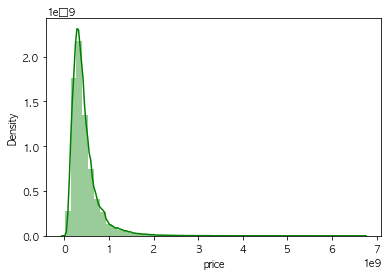

In [13]:
# 종속변수 편향도 & 첨도
print("Price Skew: ", train_df.price.skew())
print("Price Kurtosis: %f" % train_df.price.kurt())

sns.distplot(train_df.price, color='green')
plt.show()

Price Skew:  0.20894655536409165
Price Kurtosis: 0.485146


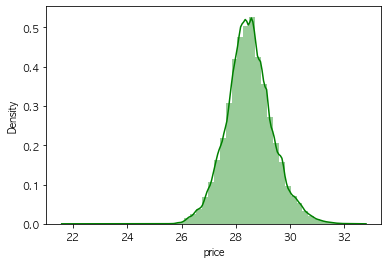

In [14]:
log_price = np.log2(train_df.price)

print("Price Skew: ", log_price.skew())
print("Price Kurtosis: %f" % log_price.kurt())

sns.distplot(log_price, color='green')
plt.show()

In [15]:
# 종속변수 - 독립변수 상관관계
corr = numeric_features.corr()
print (corr['price'].sort_values(ascending=False))

price                       1.000000
supplyArea                  0.658616
exclusiveArea               0.652691
maxSupplyArea               0.570340
roomCnt                     0.501385
parkingCountByHousehold     0.452651
minSupplyArea               0.436999
bathroomCnt                 0.412517
highFloor                   0.297713
contactDay                  0.288454
exclusiveRate               0.284920
totalDongCount              0.211858
lowFloor                    0.183260
floor                       0.162933
totalHouseholdCount         0.119233
constructYear               0.104106
longitude                   0.085150
householdCountByPyeong      0.011781
floorRate                   0.010887
batlRatio                  -0.006500
distHospital               -0.072644
volume                     -0.082593
btlRatio                   -0.100616
distStation                -0.105543
distHangang                -0.131017
totalLeaseHouseholdCount   -0.178921
latitude                   -0.306248
N

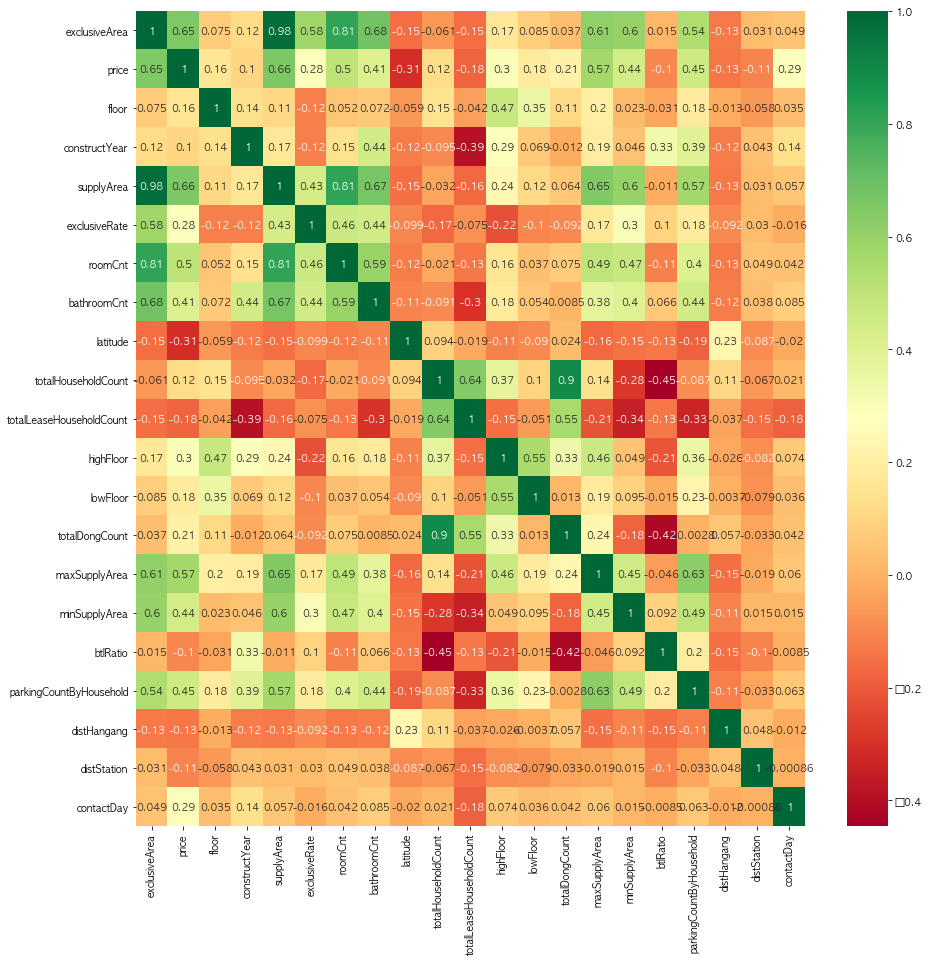

In [16]:
# 히트맵 시각화
corrmat = train_df.corr()
top_corr_features = corrmat.index[abs(corrmat['price']) > 0.1]
plt.figure(figsize=(15, 15))
g = sns.heatmap(train_df[top_corr_features].corr(), annot=True, cmap="RdYlGn")

# supplyArea와 exclusiveArea의 상관계수가 0.98으로 상관관계가 매우 높다(매우 당연하다...!)
# totalDongCount와 totalHouseholdCount의 상관계수가 0.9로 높다

In [17]:
# 상관계수가 높은 컬럼(totalHouseholdCount, exclusiveArea) 삭제
train_df.drop(['totalHouseholdCount', 'exclusiveArea'], axis=1, inplace=True)

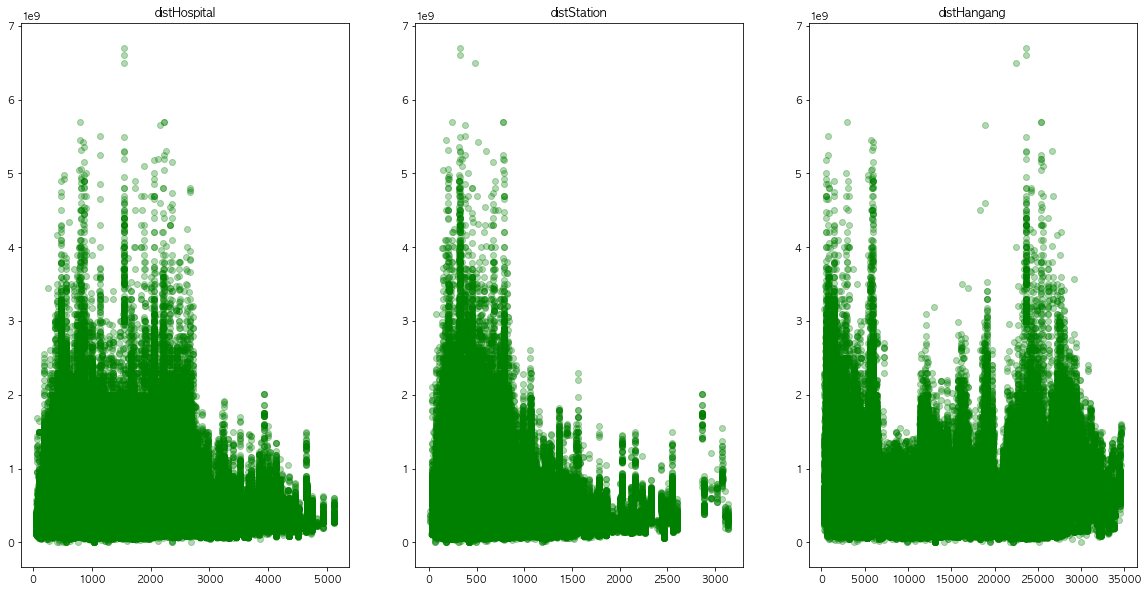

In [18]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 10))
axes = np.ravel(axes)
col_name = ['distHospital', 'distStation', 'distHangang']
for i, c in zip(range(len(col_name)), col_name):
    axes[i].scatter(train_df[c], train_df['price'], alpha=0.3, c='green')
    axes[i].set_title(c)

plt.show()

In [19]:
# 컬럼별 결측치 비율
train_df.isnull().sum()/train_df.shape[0]*100

detailAddress                0.000000
complexName                  0.000000
price                        0.000000
floor                        0.000000
constructYear                0.000000
roadAddress                  0.000000
supplyArea                   0.000000
householdCountByPyeong       0.001893
realEstateTypeCode           0.000000
exclusiveRate                0.000000
entranceType                 0.000000
roomCnt                      0.021202
bathroomCnt                  0.021202
latitude                     0.000000
longitude                    0.000000
totalLeaseHouseholdCount    92.379860
highFloor                    0.000000
lowFloor                     0.000000
totalDongCount               0.001262
maxSupplyArea                0.000000
minSupplyArea                0.009844
batlRatio                    4.918051
btlRatio                    10.493610
parkingCountByHousehold      4.659718
heatMethodTypeCode           0.042908
heatFuelTypeCode             0.040384
address     

In [20]:
# 결측치가 너무 많은 totalLeaseHouseholdCount, btlRatio, parkingCountByHousehold, batlRatio열 삭제
train_df.drop(['totalLeaseHouseholdCount', 'btlRatio', 'parkingCountByHousehold', 'batlRatio'], axis=1, inplace=True)

In [21]:
# 레코드 중 NaN이 있는 레코드 개수(False)
(train_df.isnull().sum(1) == 0).value_counts()

True     791456
False       931
dtype: int64

In [22]:
# 결측값이 있는 행 삭제
train_df.dropna(inplace=True)

In [46]:
# 컬럼별 결측값 개수
train_df.isnull().sum()

# 결측값이 모두 제거됨

price                     0
floor                     0
constructYear             0
supplyArea                0
householdCountByPyeong    0
                         ..
효성중공업                     0
흥해                        0
흥화공업                      0
희연                        0
희훈                        0
Length: 778, dtype: int64

In [24]:
# 데이터 처리 후 상관관계
numeric_features = train_df.select_dtypes(include=[np.number])
corr = numeric_features.corr()
print (corr['price'].sort_values(ascending=False))

price                     1.000000
supplyArea                0.658869
maxSupplyArea             0.570246
roomCnt                   0.501339
minSupplyArea             0.437300
bathroomCnt               0.412446
highFloor                 0.297595
contactDay                0.288407
exclusiveRate             0.284382
totalDongCount            0.211806
lowFloor                  0.183092
floor                     0.162881
constructYear             0.104326
longitude                 0.085169
householdCountByPyeong    0.011695
floorRate                 0.010956
distHospital             -0.072555
volume                   -0.082662
distStation              -0.105865
distHangang              -0.130673
latitude                 -0.306036
Name: price, dtype: float64


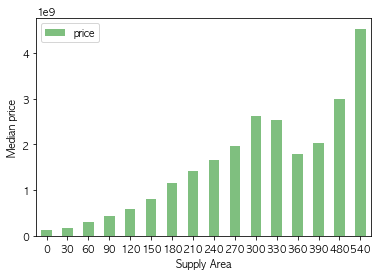

In [25]:
train_df['supplyAreaRange'] = train_df['supplyArea'].apply(lambda x: int(x/30)*30)
quality_pivot = train_df.pivot_table(index='supplyAreaRange', values='price', aggfunc=np.median)
quality_pivot.plot(kind='bar', color='green', alpha = 0.5)
plt.xlabel('Supply Area')
plt.ylabel('Median price')
plt.xticks(rotation=0)
plt.show()

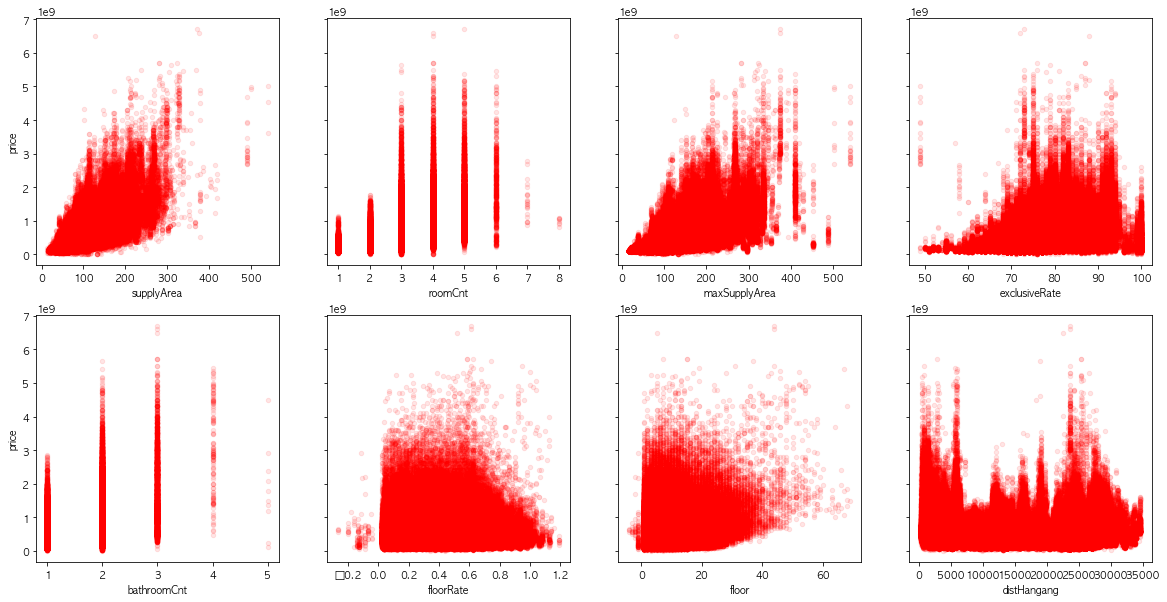

In [26]:
# 주요 컬럼 시각화
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
axes = np.ravel(axes)
col_name = ['supplyArea','roomCnt','maxSupplyArea','exclusiveRate', 'bathroomCnt', 'floorRate', 'floor', 'distHangang']
for i, c in zip(range(len(col_name)), col_name):
    train_df.plot.scatter(ax=axes[i], x=c, y='price', sharey=True, colorbar=False, color='red', alpha = 0.1)   

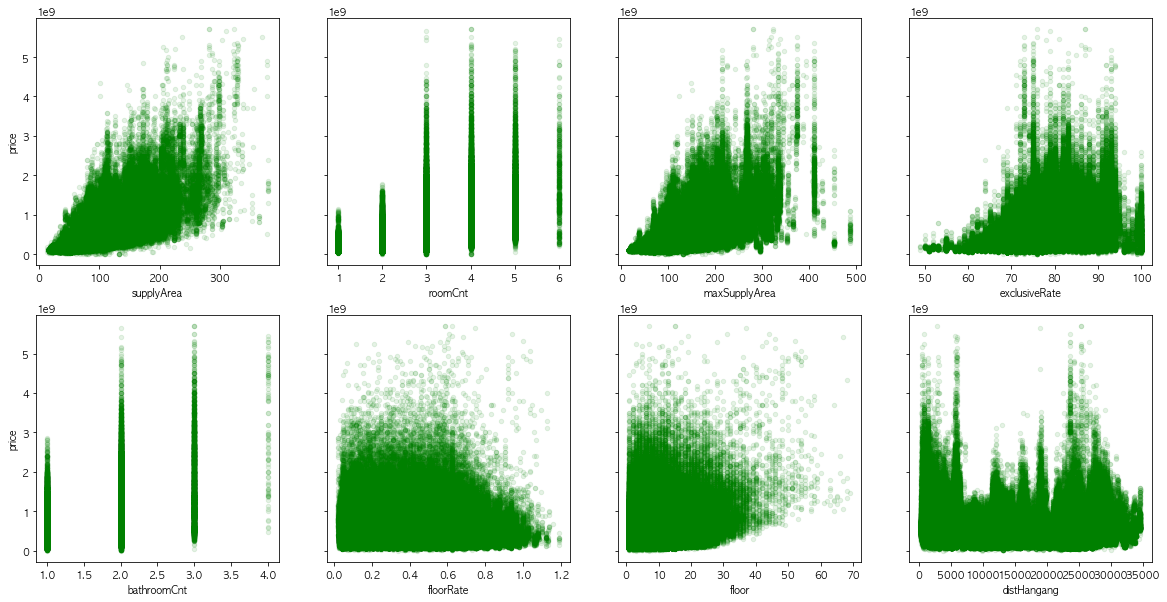

In [27]:
# 이상치 제거
train_df = train_df[train_df['price'] < 6000000000]
train_df = train_df[train_df['supplyArea'] < 450]
train_df = train_df[train_df['roomCnt'] < 7]
train_df = train_df[train_df['maxSupplyArea'] < 500]
train_df = train_df[(train_df['exclusiveRate']>60) | (train_df['price']<1000000000)]
train_df = train_df[train_df['bathroomCnt'] < 5]
train_df = train_df[train_df['floorRate'] >= 0]

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
axes = np.ravel(axes)
for i, c in zip(range(len(col_name)), col_name):
    train_df.plot.scatter(ax=axes[i], x=c, y='price', sharey=True, colorbar=False, color='green', alpha = 0.1)   

In [28]:
# 카테고리형 컬럼 
categoricals = train_df.select_dtypes(exclude=[np.number])

for c in categoricals.columns:
    print('{:<14}'.format(c), train_df[c].unique())

detailAddress  ['713' '655-2' '658-1' ... '51-11' '1546' '1005']
complexName    ['브라운스톤방학아파트' '개포2차현대아파트(220)' '개포6차우성아파트1동~8동' ... '하니맨션' '(1546-0)'
 '(578-5)201호 미공시']
roadAddress    ['도봉로146길 36' '언주로 103' '언주로 3' ... '난계로15길 36-6' '난계로13길 36' '망우로 297']
realEstateTypeCode ['A01' 'A03']
entranceType   ['계단식' '복도식' '복합식']
heatMethodTypeCode ['HT001' 'HT002' 'HT005' 'HT003']
heatFuelTypeCode ['HF001' 'HF002' 'HF004' 'HF007' 'HF003']
address        ['서울시 도봉구 방학동' '서울시 강남구 개포동' '서울시 강남구 논현동' '서울시 강남구 대치동' '서울시 강남구 도곡동'
 '서울시 강남구 삼성동' '서울시 강남구 세곡동' '서울시 강남구 수서동' '서울시 강남구 신사동' '서울시 강남구 압구정동'
 '서울시 강남구 역삼동' '서울시 강남구 일원동' '서울시 강남구 자곡동' '서울시 강남구 청담동' '서울시 강동구 강일동'
 '서울시 강동구 고덕동' '서울시 강동구 길동' '서울시 강동구 둔촌동' '서울시 강동구 명일동' '서울시 강동구 상일동'
 '서울시 강동구 성내동' '서울시 강동구 암사동' '서울시 강동구 천호동' '서울시 강북구 미아동' '서울시 강북구 번동'
 '서울시 강북구 수유동' '서울시 강북구 우이동' '서울시 강서구 가양동' '서울시 강서구 공항동' '서울시 강서구 내발산동'
 '서울시 강서구 등촌동' '서울시 강서구 마곡동' '서울시 강서구 방화동' '서울시 강서구 염창동' '서울시 강서구 화곡동'
 '서울시 관악구 남현동' '서울시 관악구 봉천동' '서울시 관악구 신림동' '서울시 광진

In [29]:
# 학습에 쓸모없는 열 삭제
train_df.drop(['detailAddress', 'complexName', 'roadAddress', 'nameHospital', 'nameStation'], axis=1, inplace=True)

In [30]:
# 카테고리형 컬럼 원핫인코딩
columns = train_df.select_dtypes(exclude=[np.number]).columns

for c in columns:
    oh_df = pd.get_dummies(train_df[c])
    train_df = pd.concat([train_df, oh_df], axis=1)
    train_df.drop(c, axis=1)

train_df.shape

(791248, 784)

In [31]:
# 원핫인코딩한 열 삭제
train_df.drop(columns, axis=1, inplace=True)

In [32]:
# 피처/레이블 분리
X = train_df.drop('price', axis=1)
y = train_df['price']
y = np.log2(y)

columns = X.columns.to_list()

In [33]:
# 피처 스케일링
minmaxscaler = MinMaxScaler()
X_scale = minmaxscaler.fit_transform(X)
X_scale = pd.DataFrame(X_scale, columns=columns)

In [34]:
# 피쳐 추출용 머신러닝 학습/테스트 데이터 분리
X_train_for_ml, X_test_for_ml, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=1)

In [35]:
# 피쳐 추출용 모델
# RandomForest
random_forest_regressor = RandomForestRegressor(n_estimators=100, n_jobs=-1)
random_forest_regressor = random_forest_regressor.fit(X_train_for_ml, y_train)
y_pred_rf = random_forest_regressor.predict(X_test_for_ml)

print('The accuracy of the Random Forset is', r2_score(y_test,y_pred_rf))
print ('RMSE is: ', mean_squared_error(y_test, y_pred_rf)**0.5)
print('\n')

The accuracy of the Random Forset is 0.9841262402043583
RMSE is:  0.10658032217010871




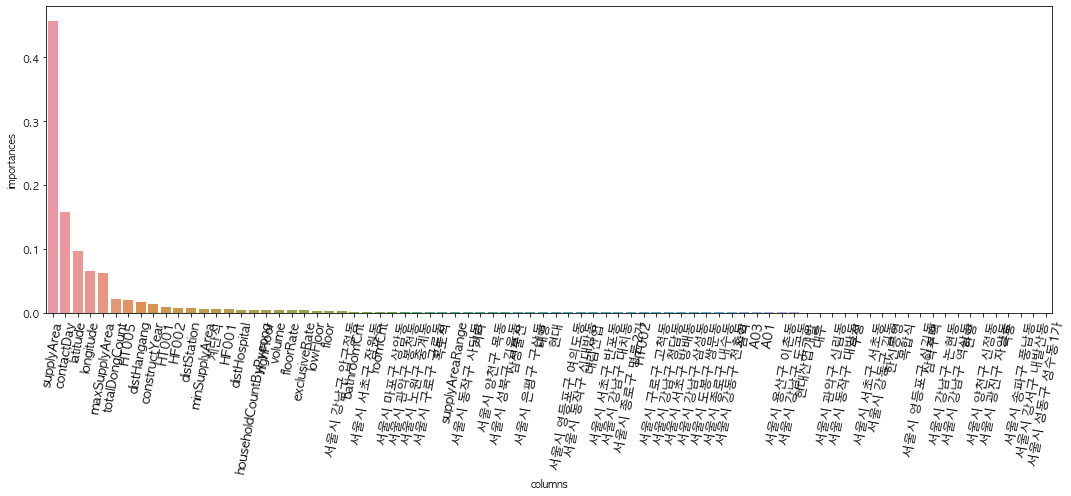

           columns  importances
2       supplyArea     0.457232
17      contactDay     0.157940
7         latitude     0.097153
8        longitude     0.065421
12   maxSupplyArea     0.062453
..             ...          ...
76     서울시 광진구 자양동     0.000058
384             극동     0.000057
221    서울시 송파구 풍납동     0.000055
63    서울시 강서구 내발산동     0.000054
174  서울시 성동구 성수동1가     0.000053

[80 rows x 2 columns]


In [36]:
# 피처 중요도
feature_importance = random_forest_regressor.feature_importances_
threshold_fi = 0.00005

df_fi = pd.DataFrame({'columns':X_train_for_ml.columns, 'importances':feature_importance})
df_fi = df_fi[df_fi['importances'] > threshold_fi] # importance가 0.0001이상인 것만 
df_fi = df_fi.sort_values(by=['importances'], ascending=False)

fig = plt.figure(figsize=(15,7))
ax = sns.barplot(df_fi['columns'], df_fi['importances'])
ax.set_xticklabels(df_fi['columns'], rotation=80, fontsize=13)
plt.tight_layout()
plt.show()
print(df_fi[df_fi['importances'] > threshold_fi])

In [37]:
# 중요도가 0.00005 이상인 열만 추출
importantFeatures = df_fi[df_fi['importances'] > threshold_fi]['columns'].to_list()

train_df_fi = X_scale[importantFeatures]

print(len(importantFeatures))

80


In [41]:
# 머신러닝 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(train_df_fi, y, test_size = 0.2, random_state=1)

In [47]:
X_train.drop(['contactDay'], axis=1, inplace=True)
X_test.drop(['contactDay'], axis=1, inplace=True)

In [81]:
print(X_train.head(1))
print(X_train.shape)

        supplyArea  contactDay  latitude  longitude  maxSupplyArea  \
169285     0.22749    0.974995  0.256461   0.088762       0.261393   

        totalDongCount  HT005  distHangang  constructYear  HT001  ...  \
169285         0.07438    0.0     0.380077            0.6    1.0  ...   

        서울시 강남구 논현동  서울시 영등포구 신길동  서울시 강서구 내발산동  서울시 광진구 자양동  삼익주택  \
169285          0.0           0.0           0.0          0.0   0.0   

        서울시 양천구 신정동  서울시 송파구 송파동   한양  서울시 종로구 사직동  서울시 동대문구 장안동  
169285          0.0          0.0  0.0          0.0           0.0  

[1 rows x 80 columns]
(632998, 80)


In [48]:
# RandomForest 학습
random_forest_regressor = RandomForestRegressor(n_estimators=200, n_jobs=-1)
random_forest_regressor = random_forest_regressor.fit(X_train, y_train)
y_pred_rf = random_forest_regressor.predict(X_test)

print('The accuracy of the Random Forset is', r2_score(y_test,y_pred_rf))
print ('RMSE is: ', mean_squared_error(y_test, y_pred_rf)**0.5)
print('\n')

KeyboardInterrupt: 

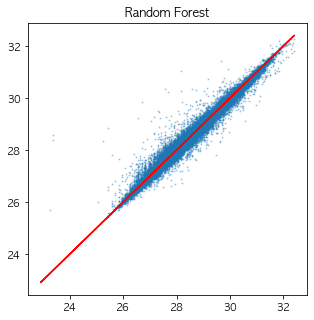

In [83]:
# Random Forest Result Visualization
fig = plt.figure(figsize=(5,5))
plt.scatter(y_test,y_pred_rf, alpha=0.3, s=1)
plt.plot(y_test,y_test,'r')
plt.title('Random Forest')
plt.show()

In [49]:
# DecisionTree 학습
decision_tree_regressor = DecisionTreeRegressor(max_depth=24, random_state=0)
decision_tree_regressor = decision_tree_regressor.fit(X_train, y_train)
y_pred_dt = decision_tree_regressor.predict(X_test)

print('The accuracy of the Decision Tree is',r2_score(y_test,y_pred_dt))
print ('RMSE is: ', mean_squared_error(y_test, y_pred_dt)**0.5)
print('\n')


The accuracy of the Decision Tree is 0.8090268206113612
RMSE is:  0.3696777530410365




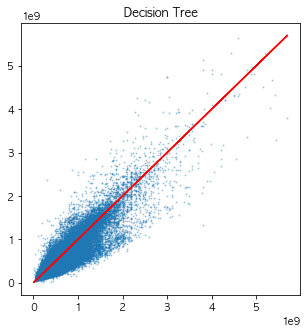

The accuracy of the Decision Tree is 0.8248877151815135
RMSE is:  136394749.59339356




In [53]:
# Decision Tree Result Visualization
fig = plt.figure(figsize=(5,5))
plt.scatter(np.exp2(y_test),np.exp2(y_pred_dt), alpha=0.3, s=1)
plt.plot(np.exp2(y_test),np.exp2(y_test),'r')
plt.title('Decision Tree')
plt.show()

print('The accuracy of the Decision Tree is',r2_score(np.exp2(y_test),np.exp2(y_pred_dt)))
print ('RMSE is: ', mean_squared_error(np.exp2(y_test), np.exp2(y_pred_dt))**0.5)
print('\n')


In [86]:
# XGBoost 학습
xgboost_regressor = XGBRegressor(max_depth=13)
xgboost_regressor = xgboost_regressor.fit(X_train, y_train)

y_pred_xgb = xgboost_regressor.predict(X_test)
print('The accuracy of the XGBoost is', r2_score(y_test,y_pred_xgb))
print ('RMSE is: ', mean_squared_error(y_test, y_pred_xgb)**0.5)
print('\n')

The accuracy of the XGBoost is 0.9837218796146261
RMSE is:  0.10792927371462363




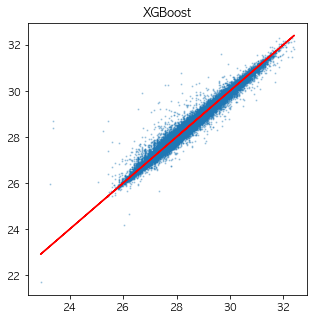

In [87]:
# XGBoost Result Visualization
fig = plt.figure(figsize=(5,5))
plt.scatter(y_test,y_pred_xgb, alpha=0.3, s=1)
plt.plot(y_test,y_test,'r')
plt.title('XGBoost')
plt.show()

In [39]:
from tensorflow.keras.layers import BatchNormalization
# DNN 1 layer 구조
dnn_layer_1 = Sequential()
dnn_layer_1.add(Dense(80,activation='relu'))
dnn_layer_1.add(Dense(256,activation='relu'))
dnn_layer_1.add(BatchNormalization())
dnn_layer_1.add(Dense(1))

dnn_layer_1.compile(optimizer='Adam',loss='mse')

In [42]:
# DNN 1 layer 학습

#dnn_layer_1 = tf.keras.models.load_model('dnn_layer_1.h5')

history_layer_1 = dnn_layer_1.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=256,epochs=200)
dnn_layer_1.summary()

dnn_layer_1.save('dnn_layer_1.h5')

Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

2473/2473 [==============================] - 4s 2ms/step - loss: 39.8554 - val_loss: 0.1082
Epoch 2/200
2473/2473 [==============================] - 4s 1ms/step - loss: 0.0740 - val_loss: 0.1346
Epoch 3/200
2473/2473 [==============================] - 4s 2ms/step - loss: 0.0574 - val_loss: 0.0427
Epoch 4/200
2473/2473 [==============================] - 4s 2ms/step - loss: 0.0511 - val_loss: 0.0583
Epoch 5/200
2473/2473 [==============================] - 4s 1ms/step - loss: 0.0459 - val_loss:

2473/2473 [==============================] - 3s 1ms/step - loss: 0.0265 - val_loss: 0.0192
Epoch 74/200
2473/2473 [==============================] - 3s 1ms/step - loss: 0.0265 - val_loss: 0.0498
Epoch 75/200
2473/2473 [==============================] - 3s 1ms/step - loss: 0.0263 - val_loss: 0.0202
Epoch 76/200
2473/2473 [==============================] - 3s 1ms/step - loss: 0.0262 - val_loss: 0.0198
Epoch 77/200
2473/2473 [==============================] - 3s 1ms/step - loss: 0.0258 - val_loss: 0.0214
Epoch 78/200
2473/2473 [==============================] - 3s 1ms/step - loss: 0.0258 - val_loss: 0.0346
Epoch 79/200
2473/2473 [==============================] - 3s 1ms/step - loss: 0.0258 - val_loss: 0.0310
Epoch 80/200
2473/2473 [==============================] - 3s 1ms/step - loss: 0.0259 - val_loss: 0.0194
Epoch 81/200
2473/2473 [==============================] - 3s 1ms/step - loss: 0.0262 - val_loss: 0.0253
Epoch 82/200
2473/2473 [==============================] - 3s 1ms/step - loss:

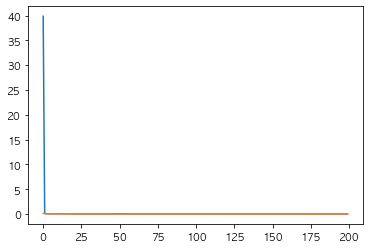

In [43]:
plt.plot(history_layer_1.history['loss'])
plt.plot(history_layer_1.history['val_loss'])
plt.show()

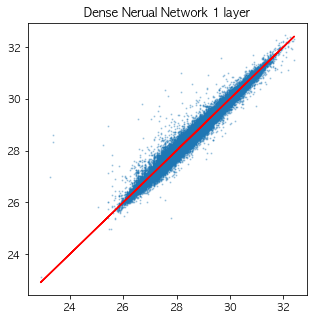

The accuracy of the Nerual Network is 0.975227466513613
RMSE is:  0.13314422640154847


In [44]:
# DNN 1 layer Result Visualization
y_pred_dnn_1 = dnn_layer_1.predict(X_test)

fig = plt.figure(figsize=(5,5))
plt.scatter(y_test,y_pred_dnn_1, alpha=0.3, s=1)
plt.plot(y_test,y_test,'r')
plt.title('Dense Nerual Network 1 layer')
plt.show()

print('The accuracy of the Nerual Network is', r2_score(y_test, y_pred_dnn_1))
print ('RMSE is: ', mean_squared_error(y_test, y_pred_dnn_1)**0.5)

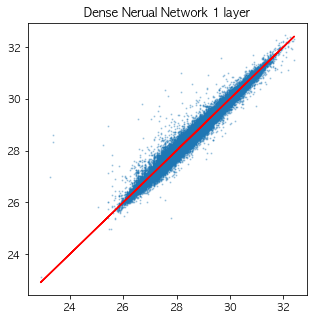

The accuracy of the Nerual Network is 0.9727807235577407
RMSE is:  53774655.113005266


In [45]:
fig = plt.figure(figsize=(5,5))
plt.scatter(y_test,y_pred_dnn_1, alpha=0.3, s=1)
plt.plot(y_test,y_test,'r')
plt.title('Dense Nerual Network 1 layer')
plt.show()

print('The accuracy of the Nerual Network is', r2_score(np.exp2(y_test), np.exp2(y_pred_dnn_1)))
print ('RMSE is: ', mean_squared_error(np.exp2(y_test), np.exp2(y_pred_dnn_1))**0.5)

In [96]:
# DNN 2 layer 구조

dnn_layer_2 = Sequential()
dnn_layer_2.add(Dense(80,activation='relu'))
dnn_layer_2.add(Dense(128,activation='relu'))
dnn_layer_2.add(Dropout(0.1))
dnn_layer_2.add(Dense(128,activation='relu'))
dnn_layer_2.add(Dropout(0.1))
dnn_layer_2.add(Dense(1))

dnn_layer_2.compile(optimizer='Adam',loss='mse')

In [98]:
# DNN 2 layer 학습

dnn_layer_2 = tf.keras.models.load_model('dnn_layer_2.h5')

history_layer_2 = dnn_layer_2.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=256,epochs=100)
dnn_layer_2.summary()

dnn_layer_2.save('dnn_layer_2.h5')

Epoch 1/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.7884 - val_loss: 0.0431
Epoch 2/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.7256 - val_loss: 0.0499
Epoch 3/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.6642 - val_loss: 0.0612
Epoch 4/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.6078 - val_loss: 0.0502
Epoch 5/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.5528 - val_loss: 0.0357
Epoch 6/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.4974 - val_loss: 0.0401
Epoch 7/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.4442 - val_loss: 0.0367
Epoch 8/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.4014 - val_loss: 0.0409
Epoch 9/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.3586 - val_loss: 0.0379
Epoch 10/100
2473/2473 [==============================] - 4s 2ms/step - l

Epoch 80/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.0228 - val_loss: 0.0212
Epoch 81/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.0228 - val_loss: 0.0232
Epoch 82/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.0228 - val_loss: 0.0231
Epoch 83/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.0227 - val_loss: 0.0228
Epoch 84/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.0226 - val_loss: 0.0226
Epoch 85/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.0227 - val_loss: 0.0224
Epoch 86/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.0227 - val_loss: 0.0213
Epoch 87/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.0226 - val_loss: 0.0231
Epoch 88/100
2473/2473 [==============================] - 4s 2ms/step - loss: 0.0226 - val_loss: 0.0256
Epoch 89/100
2473/2473 [==============================] - 4s 2ms

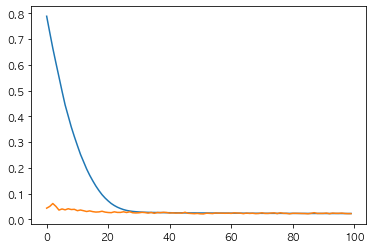

In [99]:
plt.plot(history_layer_2.history['loss'])
plt.plot(history_layer_2.history['val_loss'])
plt.show()

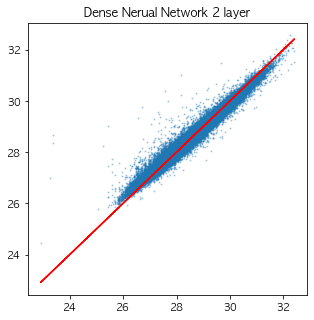

The accuracy of the Nerual Network is 0.9692448384038901
RMSE is:  0.14196110513798824


In [100]:
# DNN 2 layer Result Visualization
y_pred_dnn_2 = dnn_layer_2.predict(X_test)

fig = plt.figure(figsize=(5,5))
plt.scatter(y_test,y_pred_dnn_2, alpha=0.3, s=1)
plt.plot(y_test,y_test,'r')
plt.title('Dense Nerual Network 2 layer')
plt.show()

print('The accuracy of the Nerual Network is', r2_score(y_test, y_pred_dnn_2))
print ('RMSE is: ', mean_squared_error(y_test, y_pred_dnn_1)**0.5)

The accuracy of decision tree is 0.9694168520520527
RMSE is:  0.1479374809725921


The accuracy of random forest is 0.9842599692671581
RMSE is:  0.10613042774100893


The accuracy of xgboost is 0.9837218796146261
RMSE is:  0.10792927371462363


The accuracy of dnn 1 layer is 0.9718379354245008
RMSE is:  0.14196110513798824


The accuracy of dnn 2 layers is 0.9692448384038901
RMSE is:  0.14835293173564917




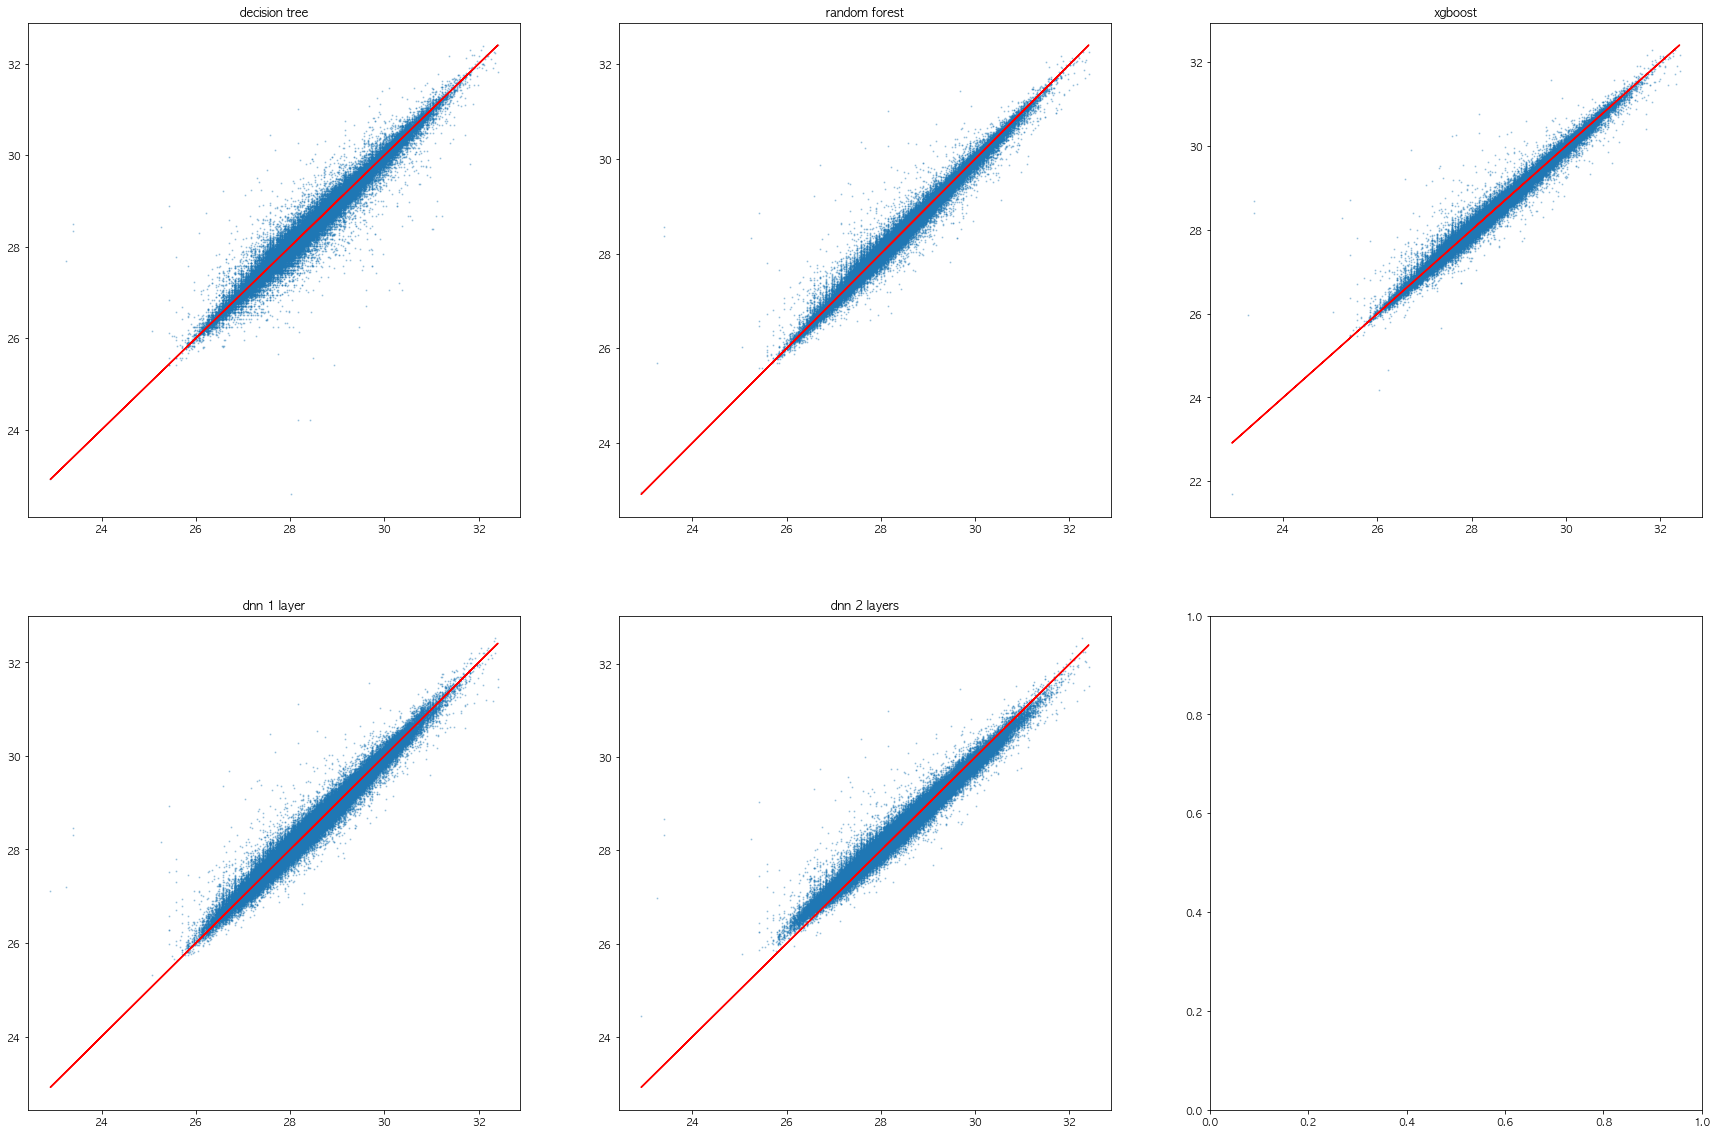

In [123]:
dnn_1 = tf.keras.models.load_model('layer1.h5')
dnn_2 = tf.keras.models.load_model('layer4.h5')

# 모델 학습 결과 시각화
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(30, 20))
axes = np.ravel(axes)


y_pred_dt = decision_tree_regressor.predict(X_test)
y_pred_rf = random_forest_regressor.predict(X_test)
y_pred_xgb = xgboost_regressor.predict(X_test)
y_pred_dnn_1 = dnn_layer_1.predict(X_test)
y_pred_dnn_2 = dnn_layer_2.predict(X_test)

y_preds = [y_pred_dt, y_pred_rf, y_pred_xgb, y_pred_dnn_1, y_pred_dnn_2]
model_types = ['decision tree', 'random forest', 'xgboost', 'dnn 1 layer', 'dnn 2 layers']

for i, pred in enumerate(y_preds):
    axes[i].scatter(y_test,pred, alpha=0.3, s=1)
    axes[i].plot(y_test,y_test,'r')
    axes[i].set_title(model_types[i])
    
    print('The accuracy of ' + model_types[i] + ' is', r2_score(y_test, pred))
    print ('RMSE is: ', mean_squared_error(y_test, pred)**0.5)
    print('\n')
        
plt.show()

In [39]:
models = [
    RandomForestRegressor(n_estimators=100, n_jobs=-1),
    XGBRegressor(max_depth=13),
    DecisionTreeRegressor(max_depth=24, random_state=0)
]

S_train, S_test = stacking(models, 
                           X_train, 
                           y_train, 
                           X_test, 
                           regression = True, 
                           metric = mean_squared_error, 
                           n_folds = 4, 
                           stratified = True, 
                           shuffle = True, 
                           random_state = 1, 
                           verbose = 2
                          )


task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]
    fold  0:  [0.01242726]
    fold  1:  [0.01330247]
    fold  2:  [0.01355270]
    fold  3:  [0.01273975]
    ----
    MEAN:     [0.01300554] + [0.00044514]
    FULL:     [0.01300554]

model  1:     [XGBRegressor]
    fold  0:  [0.01243144]
    fold  1:  [0.01286712]
    fold  2:  [0.01324914]
    fold  3:  [0.01233781]
    ----
    MEAN:     [0.01272138] + [0.00036433]
    FULL:     [0.01272138]

model  2:     [DecisionTreeRegressor]
    fold  0:  [0.02422168]
    fold  1:  [0.02531675]
    fold  2:  [0.02514742]
    fold  3:  [0.02406685]
    ----
    MEAN:     [0.02468818] + [0.00054993]
    FULL:     [0.02468818]



In [61]:
xgb_final = XGBRegressor(max_depth=8)
xgb_final = xgb_final.fit(S_train, y_train)
y_pred_final = xgb_final.predict(S_test)

The accuracy of stacking ensemble is 0.986091555031202
RMSE is:  0.09976458833388802




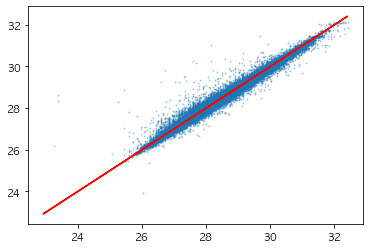

In [58]:
plt.scatter(y_test, y_pred_final, alpha=0.3, s=1)
plt.plot(y_test,y_test,'r')
    
print('The accuracy of stacking ensemble is', r2_score(y_test, y_pred_final))
print ('RMSE is: ', mean_squared_error(y_test, y_pred_final)**0.5)
print('\n')

The accuracy of result is 0.9829324553637891
RMSE is:  42581883.67125446




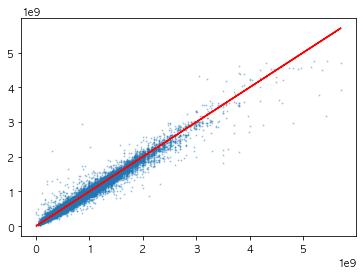

In [62]:
y_test_orig = np.exp2(y_test)
y_pred_orig = np.exp2(y_pred_final)

print('The accuracy of result is', r2_score(y_test_orig, y_pred_orig))
print ('RMSE is: ', mean_squared_error(y_test_orig, y_pred_orig)**0.5)
print('\n')

plt.scatter(y_test_orig, y_pred_orig, alpha=0.3, s=1)
plt.plot(y_test_orig,y_test_orig,'r')